In [2]:
from simulation_core import *
import simpy

## What do i want from this simulation?

- Experiment with the concept of SMART DRIVER

In [ ]:
BUS_CAPACITY = 25  # Amount of passengers that each bus can carry
TRAVEL_TIME = 15    # Time it takes for a bus to travel to its destination
MAX_PASSENGERS = 500  # Maximum number of passengers that can be generated in the simulation
BASE_LAMBDA = 1 # Regulates the average arrival rate of passengers (1/lambda is the average time between arrivals)
SIMULATION_TIME = 240
PEAK_HOUR = 150  # Time in minutes when the peak hour starts (e.g., 150 minutes = 2 hours and 30 minutes)
PEAK_FACTOR = 5 # Factor by which the arrival rate increases during the peak hour
SMART_PERCENTAGE = 0.5  # Percentage of bus capacity that must be filled before the bus departs
SMART_TIME = 10  # Time the bus can wait before deciding to leave
SMART_DRIVER = True # Indicates if the bus driver is smart (True) or not (False)
TOTAL_BUSES = 4 # Total number of buses in the simulation

smart_driver = [True, False]
bus_amount  = [3,4,5]
smart_percentage = [0.5,0.7,0.8]
smart_time = [10,15,20]
configurations = []

# Execute simulations for different configurations of buses and smart drivers parameters
for SMART_PERCENTAGE in smart_percentage :
    for SMART_TIME in smart_time:
        for NUM_NAVETTE_TOTALI in bus_amount :
            for SMART_DRIVER in smart_driver:
                # Create a configuration for each combination of parameters
                configuration = Configuration(NUM_NAVETTE_TOTALI, SMART_DRIVER, SMART_TIME, SMART_PERCENTAGE, MAX_PASSENGERS)
                for i in range(20):

                    env = simpy.Environment()

                    # Passenger queue
                    passenger_queue = simpy.Store(env)

                    # This Store manages which bus is ACTIVE for boarding at any given moment
                    # It has a capacity of 1, so only ONE bus can be placed here at a time.
                    # Buses "compete" to be here.
                    bus_attivi_per_imbarco = simpy.Store(env, capacity=1)

                    # Start the bus processes
                    for i in range(NUM_NAVETTE_TOTALI):
                        navetta_obj = Bus(env, f'Bus_{i+1}', BUS_CAPACITY)
                        env.process(bus_process(env, navetta_obj, bus_attivi_per_imbarco, passenger_queue,
                                                        SMART_DRIVER= SMART_DRIVER,
                                                            SMART_TIME=SMART_TIME,
                                                                SMART_PERCENTAGE=SMART_PERCENTAGE,
                                                                    TRAVEL_TIME=TRAVEL_TIME))

                    # Start the passenger generator
                    history = []  # List to keep track of passengers for the final report
                    env.process(participant_generator(env, passenger_queue, history,
                                                    tempo_massimo_simulazione=SIMULATION_TIME,
                                                        MAX_PASSENGERS=MAX_PASSENGERS,
                                                            PEAK_HOUR=PEAK_HOUR,
                                                                BASE_LAMBDA=BASE_LAMBDA,
                                                                    PEAK_FACTOR=PEAK_FACTOR))

                    # Execute the simulation
                    print(f'--- Simulation started for {SIMULATION_TIME} minutes ---')
                    env.run(until=SIMULATION_TIME)
                    print('--- Simulation end ---')

                    configuration.history.append(history)  # Save the passenger history in the configuration
                configurations.append(configuration)

In [4]:
average_waiting_times = []
for config in configurations:
    print(f'Configurazione: {config.num_navette} navette, Smart Driver: {config.smart_driver}, Smart Time: {config.smart_time}, Smart Percentage: {config.smart_percentage}')
    total_passengers = sum(len(history) for history in config.history)
    print(f'Totale passeggeri imbarcati: {total_passengers}')
    average_waiting_times.append(sum(p.time_departure - p.time_arrival for history in config.history for p in history if p.time_departure is not None) / total_passengers)
    print(f'Tempo medio di attesa per i passeggeri: {average_waiting_times[-1]:.2f} minuti')

Configurazione: 3 navette, Smart Driver: True, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di attesa per i passeggeri: 21.05 minuti
Configurazione: 3 navette, Smart Driver: False, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di attesa per i passeggeri: 4.92 minuti
Configurazione: 4 navette, Smart Driver: True, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di attesa per i passeggeri: 8.48 minuti
Configurazione: 4 navette, Smart Driver: False, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di attesa per i passeggeri: 3.98 minuti
Configurazione: 5 navette, Smart Driver: True, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di attesa per i passeggeri: 4.32 minuti
Configurazione: 5 navette, Smart Driver: False, Smart Time: 10, Smart Percentage: 0.5
Totale passeggeri imbarcati: 10000
Tempo medio di a

(array([743., 708., 879., 771., 564., 413., 281., 220., 212., 159., 188.,
        174., 159., 184., 138., 128., 145., 167., 117., 159., 131., 142.,
        159., 120., 125., 155., 123., 107., 169., 128., 128., 147., 107.,
        142., 127.,  98., 131., 176., 111., 109., 134.,  97., 132.,  95.,
         83.,  66.,  55.,  31.,  30.,  18.]),
 array([ 0.        ,  1.38915014,  2.77830028,  4.16745042,  5.55660056,
         6.9457507 ,  8.33490084,  9.72405098, 11.11320112, 12.50235127,
        13.89150141, 15.28065155, 16.66980169, 18.05895183, 19.44810197,
        20.83725211, 22.22640225, 23.61555239, 25.00470253, 26.39385267,
        27.78300281, 29.17215295, 30.56130309, 31.95045323, 33.33960337,
        34.72875351, 36.11790365, 37.5070538 , 38.89620394, 40.28535408,
        41.67450422, 43.06365436, 44.4528045 , 45.84195464, 47.23110478,
        48.62025492, 50.00940506, 51.3985552 , 52.78770534, 54.17685548,
        55.56600562, 56.95515576, 58.3443059 , 59.73345604, 61.12260618,
 

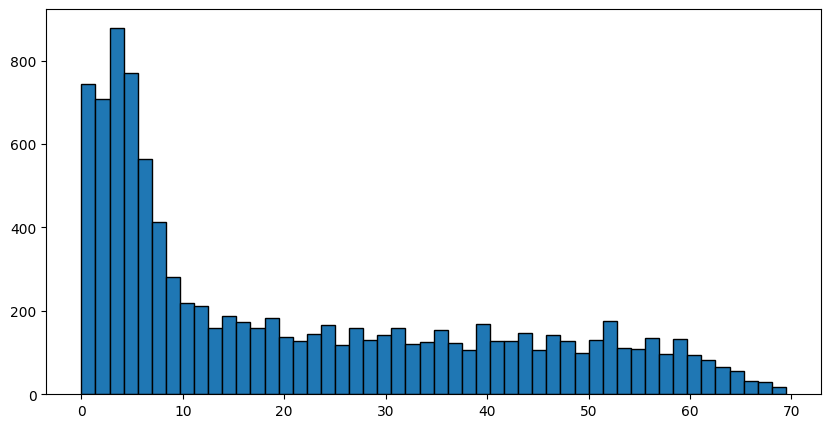

In [6]:
import matplotlib.pyplot as plt

# plot distribution of waiting times for 3 buses configuration
plt.figure(figsize=(10, 5))
waiting_times = [p.time_departure - p.time_arrival for history in configurations[0].history for p in history if p.time_departure is not None]
plt.hist(waiting_times, bins=50, edgecolor='black')

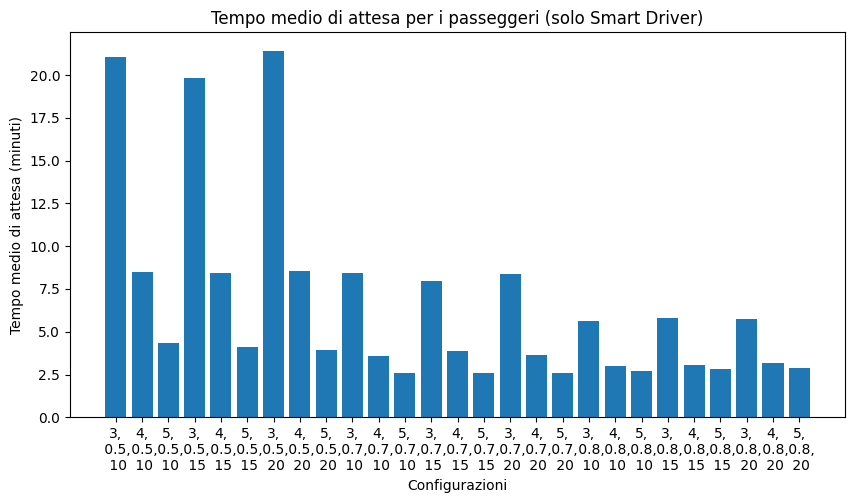

In [20]:
# plot the average waiting times for each configuration where smart driver is True 

filtered_times = [t for i, t in enumerate(average_waiting_times) if configurations[i].smart_driver]
filtered_labels = [f'{configurations[i].num_navette},\n {configurations[i].smart_percentage},\n {configurations[i].smart_time}' for i in range(len(average_waiting_times)) if configurations[i].smart_driver]

# Plotta solo quelle
plt.figure(figsize=(10, 5))
plt.bar(range(len(filtered_times)), filtered_times, tick_label=filtered_labels)
plt.xlabel('Configurazioni')
plt.ylabel('Tempo medio di attesa (minuti)')
plt.title('Tempo medio di attesa per i passeggeri (solo Smart Driver)')
plt.show()


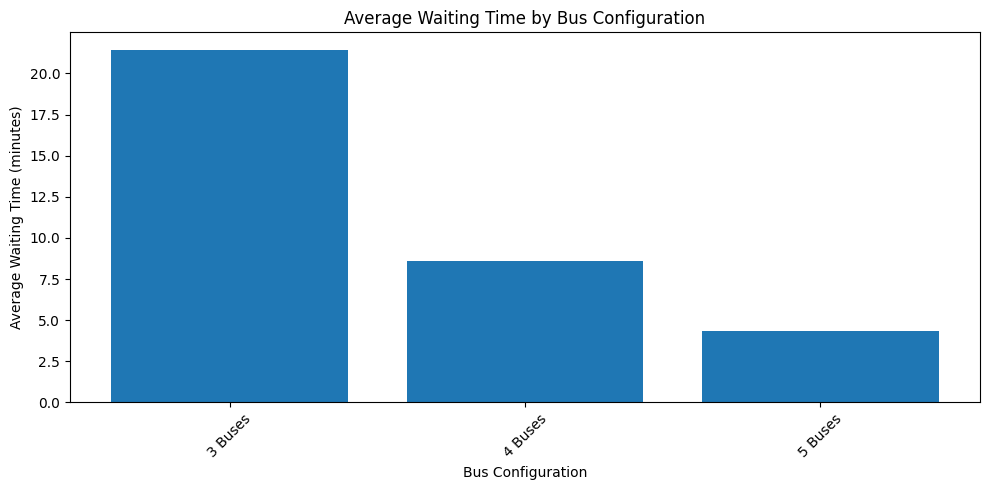

In [8]:
# Plot the average waiting times for each configuration
plt.figure(figsize=(10, 5))
plt.bar([f'{config.num_navette} Buses' for config in configurations], average_waiting_times)
plt.xlabel('Bus Configuration')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Average Waiting Time by Bus Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# print maximum waiting time for each configuration and the arrival time of the maximum waiting time
print("\nMassimo tempo di attesa per ogni configurazione:")
for config in configurations:
    for history in config.history:
        curren_max = None
        for p in history:
            if p.time_departure is not None:
                waiting_time = p.time_departure - p.time_arrival
                if curren_max is None or waiting_time > curren_max[0]:
                    curren_max = (waiting_time, p.time_arrival, config.num_navette, config.smart_driver, config.smart_time, config.smart_percentage)
        print(f'maximum waiting time: {curren_max[0]:.2f} minutes, arrival time: {curren_max[1]:.2f} minutes, configuration: {curren_max[2]} buses, smart driver: {curren_max[3]}, smart time: {curren_max[4]}, smart percentage: {curren_max[5]}')



Massimo tempo di attesa per ogni configurazione:
maximum waiting time: 67.36 minutes, arrival time: 157.13 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 65.63 minutes, arrival time: 166.15 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 61.10 minutes, arrival time: 161.09 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 69.46 minutes, arrival time: 163.49 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 64.79 minutes, arrival time: 166.41 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 60.15 minutes, arrival time: 163.79 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 67.42 minutes, arrival time: 157.6